In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", "..", ".."))

# Cross-Validation on a grid

Continuing to work with the Rosser et al. paper, we also want to cross validate the grid based "prospective hotspotting".

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import descartes
import zipfile, pickle

import open_cp.sources.chicago
import open_cp.geometry
import open_cp.prohotspot
import open_cp.predictors

In [3]:
data_path = os.path.join("/media", "disk", "Data")
#data_path = os.path.join("..", "..", "..", "..", "..", "..", "Data")
open_cp.sources.chicago.set_data_directory(data_path)
south_side = open_cp.sources.chicago.get_side("South")

In [4]:
grid = open_cp.data.Grid(xsize=150, ysize=150, xoffset=0, yoffset=0)
grid = open_cp.geometry.mask_grid_by_intersection(south_side, grid)

In [5]:
filename = open_cp.sources.chicago.get_default_filename()
timed_points = open_cp.sources.chicago.load(filename, ["BURGLARY"])
timed_points.number_data_points, timed_points.time_range

(13970,
 (numpy.datetime64('2016-05-04T05:30:00.000'),
  numpy.datetime64('2017-05-03T23:48:00.000')))

In [6]:
timed_points = open_cp.geometry.intersect_timed_points(timed_points, south_side)
timed_points.number_data_points

1985

### Use old data instead

In [7]:
filename = os.path.join(data_path, "chicago_all_old.csv")
timed_points = open_cp.sources.chicago.load(filename, ["BURGLARY"], type="all")
timed_points.number_data_points, timed_points.time_range

(326540,
 (numpy.datetime64('2001-01-01T00:01:00.000'),
  numpy.datetime64('2014-05-24T22:30:00.000')))

In [8]:
timed_points = open_cp.geometry.intersect_timed_points(timed_points, south_side)
timed_points.number_data_points

46920

# What do Rosser et al do?

They seem to use a "hybrid" approach, which we have (fortuitously) implemented as `ProspectiveHotSpotContinuous`.  That is, they use a continuous KDE method, with both a space and time component, and then convert this to a grid as a final step.

The exact formula used is
$$ \lambda(t,s) = \sum_{i : t_i<t} f(\|s-s_i\|) g(t-t_i) $$
where
$$ f(\Delta s) = \begin{cases} \frac{h_S - \Delta s}{h_S^2} & :\text{if } \Delta s \leq h_S, \\ 0 &:\text{otherwise.}
\end{cases} 
\qquad
g(\Delta t) = \frac{1}{h_T} \exp\Big( -\frac{\Delta t}{h_T} \Big). $$
Notice that this is _not normalised_ because when converting from two dimensions to a (positive) number using the Euclidean norm $\|\cdot\|$ we map the infinitesimal annulus $r \leq \sqrt{x^2+y^2} \leq r+dr$ to the interval $[r, r+dr]$; the former has area $\pi((r+dr)^2 - r^2) = 2\pi r dr$ while the latter has length $dr$.

## Normalisation

Let us think a bit harder about normalisation.  We treat $\lambda$ as a "kernel" in time and space, we presumably, mathematically, we allow $s$ to vary over the whole plane, but constrain $t\geq 0$ (assuming all events occur in positive time; in which case $\lambda$ is identically zero for $t<0$ anyway).  Thus, that $\lambda$ is "normalised" should mean that
$$ \int_0^\infty \int_{\mathbb R^2} \lambda(t, s) \ ds \ dt = 1. $$

How do we actually use $\lambda$?  In Rosser et al. it is first used to find the "optimal bandwidth selection" by constructing $\lambda$ using all events up to time $T$ and then computing the log likelihood
$$ \sum_{T \leq t_i < T+\delta} \log \lambda(t_i, s_i) $$
where, if we're using a time unit of days, $\delta=1$ (i.e. we look at the events in the next day).

To make predictions, we take point estimates of $\lambda$, or use the mean value.  How we treat space versus time is a little unclear in the literature.  There are perhaps two approaches:

1. Fix a time $t$ and then compute the mean value of $\lambda(t, s)$ as $s$ varies across the grid cell.
2. Compute the mean value of $\lambda(t, s)$ as $t$ varies across the day (or other time period) we are predicting for, and as $s$ varies across the grid cell.

Typically we use a monte carlo approach to estimate the mean from point estimates.  Currently our code implements the first method by fixing time at the start of the day.  The example below shows a roughly 2% (maximum) difference between (1) and (2) with little change if we vary the fixed time $t$ in (1).

Notice that this introduces a difference between finding the optimal bandwidth selection and making a prediction.  The former uses the exact timestamps of events, while the latter makes one prediction for the whole day, and then "validates" this against all events which occur in that day.

We thus have a number of different "normalisations" to consider.  We could normalise $\lambda$ so that it is a probability kernel-- this is needed if we are to use point evaluations of $\lambda$.  When forming a prediction, the resulting grid of values will (almost) never by normalised, as we are not integrating over all time.  Thus we should almost certainly normalise the resulting grid based prediction, if we are to compare different predictions.

## Normalising $\lambda$

After private communication with the authors, it appears they are well aware of the normalisation issue, and that this is due to a typo in the paper.  Using [Polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system#Integral_calculus_.28area.29) we wish to have that
$$ 1 = \int_0^{2\pi} \int_0^\infty r f(r) \ dr \ d\theta = 2\pi \int_0^{h_S} rf(r) \ dr. $$
The natural change to make is to define
$$ f'(\Delta s) = \begin{cases} \frac{h_S - \Delta s}{\pi h_s^2\Delta s} & :\text{if } \Delta s \leq h_S, \\ 0 &:\text{otherwise.}
\end{cases} $$
However, this introduces a singularity at $\Delta s = 0$ which is computationally hard to deal with (essentially, the monte carlo approach to integration we use becomes much noisier, as some experiments show).

An alternative is to simply divide $f$ by a suitable constant.  In our case, the constant is
$$ 2\pi \int_0^{h_S}  \frac{h_S - r}{h_S^2} r \ dr = 2\pi \Big[ \frac{r^2}{2h_S} - \frac{r^3}{3h_S^2} \Big]_0^{h_S}
= 2\pi \Big( \frac{h_S}{2} - \frac{h_S}{3} \Big)
= 2\pi \Big( \frac{h_S}{2} - \frac{h_S}{3} \Big)
= \pi h_S / 3. $$


In [9]:
predictor = open_cp.prohotspot.ProspectiveHotSpotContinuous(grid_size=150, time_unit=np.timedelta64(1, "D"))
predictor.data = timed_points[timed_points.timestamps >= np.datetime64("2013-01-01")]

In [10]:
class OurWeight():
    def __init__(self):
        self.time_bandwidth = 100
        self.space_bandwidth = 10
    
    def __call__(self, dt, dd):
        kt = np.exp(-dt / self.time_bandwidth) / self.time_bandwidth
        dd = np.atleast_1d(np.asarray(dd))
        #ks = (self.space_bandwidth - dd) / (self.space_bandwidth * self.space_bandwidth * dd * np.pi)
        ks = ((self.space_bandwidth - dd) / (self.space_bandwidth * self.space_bandwidth
                                             * np.pi * self.space_bandwidth) * 3)
        mask = dd > self.space_bandwidth
        ks[mask] = 0
        return kt * ks

In [11]:
predictor.weight = OurWeight()
predictor.weight.space_bandwidth = 1

In [12]:
tend = np.datetime64("2013-01-01") + np.timedelta64(180, "D")
prediction = predictor.predict(tend, tend)
prediction.samples = 50
grid_pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(prediction, grid)
grid_pred.mask_with(grid)
grid_pred = grid_pred.renormalise()

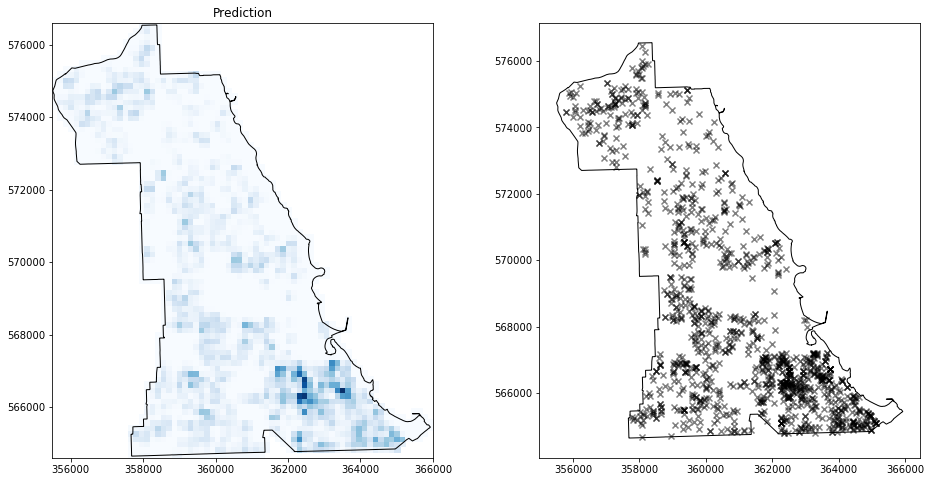

In [13]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
ax[0].pcolormesh(*grid_pred.mesh_data(), grid_pred.intensity_matrix, cmap="Blues")
ax[0].set_title("Prediction")

points = predictor.data.events_before(tend)
ax[1].scatter(points.xcoords, points.ycoords, marker="x", color="black", alpha=0.5)
None

In [14]:
grid_pred2 = predictor.grid_predict(tend, tend, tend + np.timedelta64(1, "D"), grid, samples=1)
grid_pred2.mask_with(grid)
grid_pred2 = grid_pred2.renormalise()

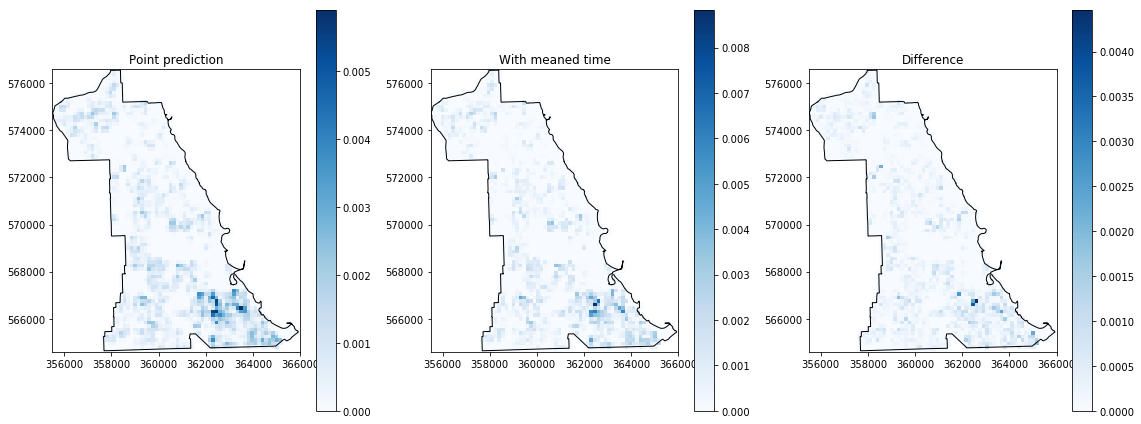

In [15]:
fig, ax  = plt.subplots(ncols=3, figsize=(16,6))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
mp = ax[0].pcolormesh(*grid_pred.mesh_data(), grid_pred.intensity_matrix, cmap="Blues")
ax[0].set_title("Point prediction")
fig.colorbar(mp, ax=ax[0])

mp = ax[1].pcolormesh(*grid_pred2.mesh_data(), grid_pred2.intensity_matrix, cmap="Blues")
ax[1].set_title("With meaned time")
fig.colorbar(mp, ax=ax[1])

mp = ax[2].pcolormesh(*grid_pred2.mesh_data(),
                      np.abs(grid_pred.intensity_matrix - grid_pred2.intensity_matrix), cmap="Blues")
ax[2].set_title("Difference")
fig.colorbar(mp, ax=ax[2])

fig.tight_layout()
None

# Direct calculation of optimal bandwidth

Following Rosser et al. closely, we don't need to form a grid prediction, and hence actually don't need to use (much of) our library code.

- We find the maximum likelihood at 500m and 35--45 days, a tighter bandwidth than Rosser et al.
- This mirrors what we saw for the network; perhaps because of using Chicago and not UK data

In [16]:
tstart = np.datetime64("2013-01-01")
tend = np.datetime64("2013-01-01") + np.timedelta64(180, "D")

def log_likelihood(start, end, weight):
    data = timed_points[(timed_points.timestamps >= tstart) & 
                       (timed_points.timestamps < start)]
    validate = timed_points[(timed_points.timestamps >= start) & 
                       (timed_points.timestamps <= end)]
    dt = validate.timestamps[None, :] - data.timestamps[:, None]
    dt = dt / np.timedelta64(1, "D")
    dx = validate.xcoords[None, :] - data.xcoords[:, None]
    dy = validate.ycoords[None, :] - data.ycoords[:, None]
    dd = np.sqrt(dx*dx + dy*dy)
    ll = np.sum(weight(dt, dd), axis=0)
    ll[ll < 1e-30] = 1e-30
    return np.sum(np.log(ll))

def score(weight):
    out = 0.0
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        out += log_likelihood(start, end, weight)
    return out

In [41]:
time_lengths = list(range(5,100,5))
space_lengths = list(range(50, 2000, 50))

scores = {}
for sl in space_lengths:
    for tl in time_lengths:
        weight = OurWeight()
        weight.space_bandwidth = sl
        weight.time_bandwidth = tl
        key = (sl, tl)
        scores[key] = score(weight)

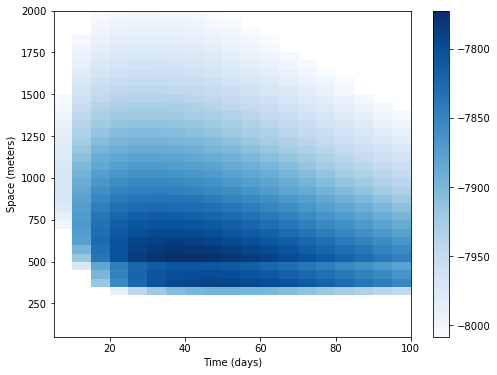

In [42]:
data = np.empty((39,19))
for i, sl in enumerate(space_lengths):
    for j, tl in enumerate(time_lengths):
        data[i,j] = scores[(sl,tl)]

ordered = data.copy().ravel()
ordered.sort()
cutoff = ordered[int(len(ordered) * 0.25)]
data = np.ma.masked_where(data<cutoff, data)

fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.pcolor(range(5,105,5), range(50,2050,50), data, cmap="Blues")
ax.set(xlabel="Time (days)", ylabel="Space (meters)")
fig.colorbar(mappable, ax=ax)
None

In [46]:
print(max(scores.values()))
[k for k, v in scores.items() if v > -7775]

-7772.56122721


[(500, 35), (500, 40), (500, 45)]

# Scoring the grid

We'll now use the grid prediction; firstly using the "fully averaged" version.

- We find the maximum likelihood at 500m and 80 days.
- I wonder what explains the slight difference from above?

In [16]:
def log_likelihood(grid_pred, timed_points):
    logli = 0
    for x, y in zip(timed_points.xcoords, timed_points.ycoords):
        risk = grid_pred.risk(x, y)
        if risk < 1e-30:
            risk = 1e-30
        logli += np.log(risk)
    return logli

In [17]:
tstart = np.datetime64("2013-01-01")
tend = np.datetime64("2013-01-01") + np.timedelta64(180, "D")

def score_grids(grids):
    out = 0
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        grid_pred = grids[start]
        mask = (predictor.data.timestamps > start) & (predictor.data.timestamps <= end)
        timed_points = predictor.data[mask]
        out += log_likelihood(grid_pred, timed_points)
    return out

def score(predictor):
    grids = dict()
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        grid_pred = predictor.grid_predict(start, start, end, grid, samples=5)
        grid_pred.mask_with(grid)
        grids[start] = grid_pred.renormalise()
    return score_grids(grids), grids

In [18]:
time_lengths = list(range(5,100,5))
space_lengths = list(range(50, 2000, 50))
predictor = open_cp.prohotspot.ProspectiveHotSpotContinuous(grid_size=150, time_unit=np.timedelta64(1, "D"))
predictor.data = timed_points[timed_points.timestamps >= np.datetime64("2013-01-01")]
predictor.weight = OurWeight()

In [19]:
results = dict()
zp = zipfile.ZipFile("grids.zip", "w", compression=zipfile.ZIP_DEFLATED)

for sl in space_lengths:
    for tl in time_lengths:
        key = (sl, tl)
        predictor.weight = OurWeight()
        predictor.weight.space_bandwidth = sl / predictor.grid
        predictor.weight.time_bandwidth = tl
        results[key], grids = score(predictor)
        with zp.open("{}_{}.grid".format(sl,tl), "w") as f:
            f.write(pickle.dumps(grids))
        print("Done", sl, tl, file=sys.__stdout__)

zp.close()

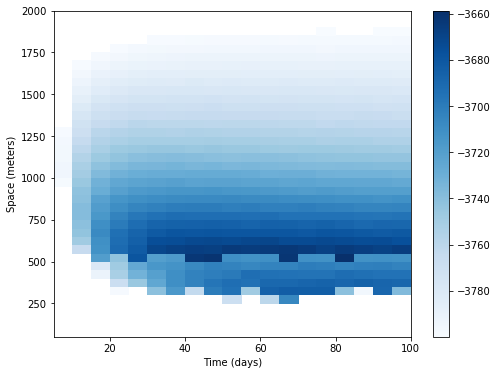

In [21]:
data = np.empty((39,19))
for i, sl in enumerate(space_lengths):
    for j, tl in enumerate(time_lengths):
        data[i,j] = results[(sl,tl)]

ordered = data.copy().ravel()
ordered.sort()
cutoff = ordered[int(len(ordered) * 0.25)]
data = np.ma.masked_where(data<cutoff, data)

fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.pcolor(range(5,105,5), range(50,2050,50), data, cmap="Blues")
ax.set(xlabel="Time (days)", ylabel="Space (meters)")
fig.colorbar(mappable, ax=ax)
None

In [23]:
print(max(results.values()))
[k for k, v in results.items() if v > -3660]

-3658.71861229


[(500, 80)]

## Where did we get to?

In [28]:
zp = zipfile.ZipFile("grids.zip")

with zp.open("500_80.grid") as f:
    grids = pickle.loads(f.read())
    one = list(grids)[0]
    one = grids[one]
with zp.open("500_90.grid") as f:
    grids = pickle.loads(f.read())
    two = list(grids)[0]
    two = grids[two]

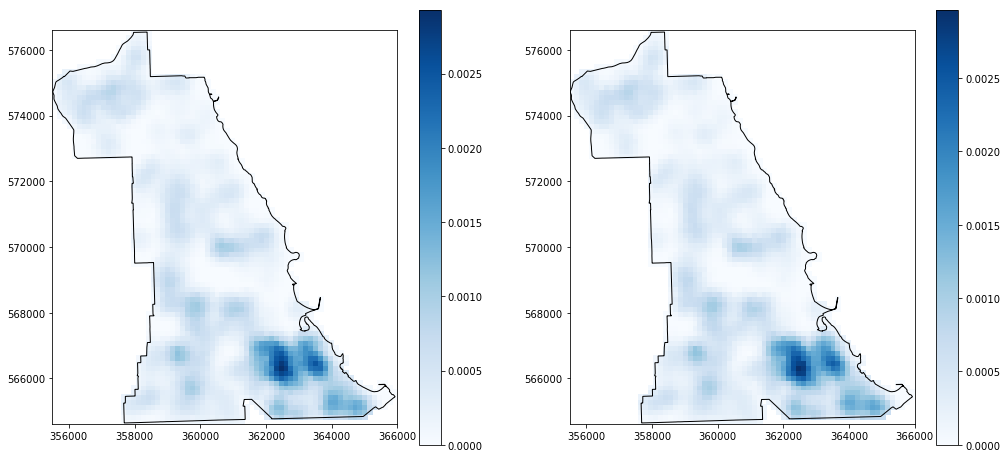

In [29]:
fig, ax  = plt.subplots(ncols=2, figsize=(17,8))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
for a, g in zip([0,1], [one,two]):
    mp = ax[a].pcolormesh(*g.mesh_data(), g.intensity_matrix, cmap="Blues")
    fig.colorbar(mp, ax=ax[a])
None

## Again, with normal grid

Instead of averaging in time, we just take a point estimate.

- We find the maximum likelihood at 500m and 60--85 days.

In [30]:
def score(predictor):
    grids = dict()
    for day in range(60):
        start = tend + np.timedelta64(1, "D") * day
        end = tend + np.timedelta64(1, "D") * (day + 1)
        prediction = predictor.predict(tend, tend)
        prediction.samples = 5
        grid_pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(prediction, grid)
        grid_pred.mask_with(grid)
        grids[start] = grid_pred.renormalise()
    return score_grids(grids), grids

In [31]:
results = dict()
zp = zipfile.ZipFile("grids.zip", "w", compression=zipfile.ZIP_DEFLATED)

for sl in space_lengths:
    for tl in time_lengths:
        key = (sl, tl)
        predictor.weight = OurWeight()
        predictor.weight.space_bandwidth = sl / predictor.grid
        predictor.weight.time_bandwidth = tl
        results[key], grids = score(predictor)
        with zp.open("{}_{}.grid".format(sl,tl), "w") as f:
            f.write(pickle.dumps(grids))
        print("Done", sl, tl, file=sys.__stdout__)

zp.close()

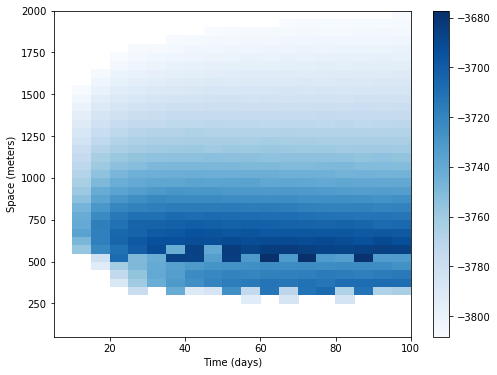

In [32]:
data = np.empty((39,19))
for i, sl in enumerate(space_lengths):
    for j, tl in enumerate(time_lengths):
        data[i,j] = results[(sl,tl)]

ordered = data.copy().ravel()
ordered.sort()
cutoff = ordered[int(len(ordered) * 0.25)]
data = np.ma.masked_where(data<cutoff, data)

fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.pcolor(range(5,105,5), range(50,2050,50), data, cmap="Blues")
ax.set(xlabel="Time (days)", ylabel="Space (meters)")
fig.colorbar(mappable, ax=ax)
None

In [35]:
print(max(results.values()))
[k for k, v in results.items() if v > -3680]

-3677.21715963


[(500, 60), (500, 70), (500, 85)]

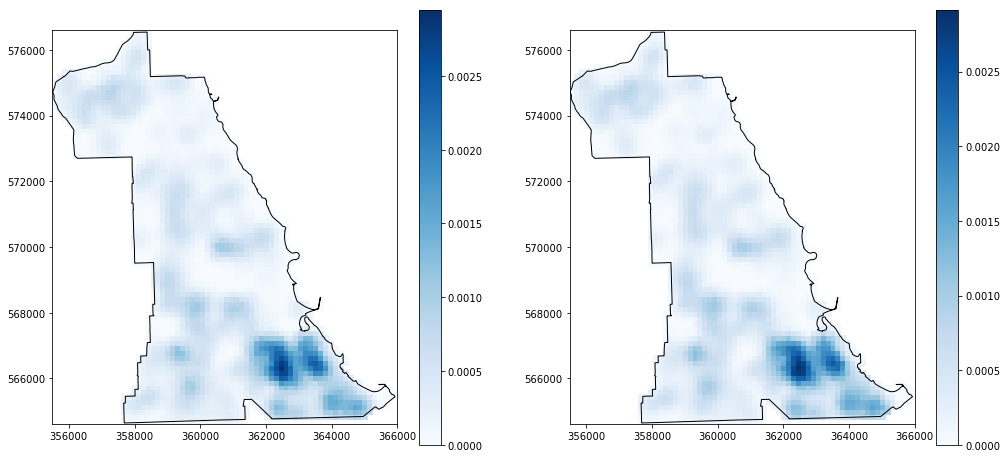

In [37]:
zp = zipfile.ZipFile("grids.zip")

with zp.open("500_80.grid") as f:
    grids = pickle.loads(f.read())
    one = list(grids)[0]
    one = grids[one]
with zp.open("500_85.grid") as f:
    grids = pickle.loads(f.read())
    two = list(grids)[0]
    two = grids[two]
    
fig, ax  = plt.subplots(ncols=2, figsize=(17,8))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
for a, g in zip([0,1], [one,two]):
    mp = ax[a].pcolormesh(*g.mesh_data(), g.intensity_matrix, cmap="Blues")
    fig.colorbar(mp, ax=ax[a])
None